In [2]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=sk-替换为自己的Qwen API Key

env: LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
env: LLM_API_KEY=sk-替换为自己的Qwen API Key


In [1]:
%env DEEPSEEK_API_KEY=sk-替换为自己的DeepSeek API Key

env: DEEPSEEK_API_KEY=sk-替换为自己的DeepSeek API Key


In [3]:
!pip install -q langchain-deepseek


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
%%capture --no-stderr
!pip install langchain langchain-community langchain-ollama langchain-deepseek langchain-openai langchain_chroma pypdf sentence_transformers shutil openpyxl FlagEmbedding

LangGraph可视化依赖

In [5]:
!sudo apt install -y graphviz libgraphviz-dev
!pip install pygraphviz

In [6]:
import os
import pandas as pd

expr_version = 'new_arch_v3_r1_reasoning_rag_671b_r1'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 加载文档

In [7]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 切分

In [8]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [9]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [10]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings


model_path = 'BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)

persist_directory = os.path.join(expr_dir, 'chroma', 'bge')
shutil.rmtree(persist_directory, ignore_errors=True)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)

device: cuda


# 构建流程

In [11]:
from langchain_deepseek import ChatDeepSeek
from langchain_ollama import ChatOllama

r1 = ChatDeepSeek(
    model="deepseek-reasoner",
    temperature=0.6,
    top_p=0.7,
    max_tokens=4096
)
# r1 = ChatOllama(model='deepseek-r1:latest', temperature=0.01)
llm = ChatOllama(model='qwen2:7b-instruct')

In [12]:
# resp = r1.invoke('为什么天空是蓝色的')
# resp.content结构为：
# <think>...</think>...

In [13]:
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict

In [14]:
class RAGState(TypedDict):
    question: str
    retrieved_context: str
    router_decision: str
    answer_to_question: str
    missing_information: str
    useful_information: str
    reasoning: str
    n_round: int

In [15]:
from langchain_core.prompts import PromptTemplate

VALIDATE_PROMPT = PromptTemplate(
    input_variables=["retrieved_context", "question"],
    template="""
# 任务描述

您是一名检索验证员。
系统会向您提供一个问题和一些背景信息，这些背景信息可能包含问题的答案，也可能不包含。
您的任务是仔细查看这些文本块，并提供包含三个字段的 JSON 响应：

1. status：检索到的背景信息是否包含问题的答案。
- 如果检索到的背景信息包含问题答案，则为 "COMPLETE"，否则为 "INCOMPLETE"。只有这两个取值，其他取值都是非法的。

2. useful_information：从检索到的背景信息中获取的有用信息。要简洁明了。
- 大部分情况下，这部分信息不能为空，如果确实没有有用信息，则将其设置为空字符串。
- 如果status是COMPLETE，则这部分一定要有。

3. missing_information：如果要完整回答这个问题，还需要的信息，这个信息将用来使用向量模型进一步检索知识库，以便补充信息。
- 如果status是INCOMPLETE，则这部分信息一定要有。

# 背景信息

---
{retrieved_context}
---

# 返回值要求
    
    请按以下格式以字典形式提供您的答复。请严格按照此格式返回结果，不要包含描述性内容和任何其他无关内容。

```json
{{"status": "<status>",
"useful_information": "<useful_information>",
"missing_information": "<missing_information>"}}
```
    
这里是响应的样例：

```json
{{"status": "COMPLETE",
"useful_information": "The capital city of Canada is Ottawa.",
"missing_information": "The capital city of Mexico"}}
```


# 问题

{question}
    """
)

ANSWER_QUESTION = PromptTemplate(
    input_variables=["retrieved_context", "question"],
    template="""
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{retrieved_context}
<<<</context>>>

问题：{question}
请回答：
    """
)

## 构建Workflow

In [16]:
import json

In [17]:
n_chunks = 3

In [18]:
import re

def extract_json(text):
    match = re.search(r'\{.*\}', text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            print("提取的内容不是有效的JSON")
    return None

In [19]:
def retrieve(state: RAGState):
    print(f"\n=== STEP 1: RETRIEVAL (round: {state.get('n_round', 0)})===")
    
    question = state['question']
    print("Searching for:", question)
    
    chunks = vector_db.similarity_search(question, k=n_chunks)
    return {'retrieved_context': '\n\n'.join([doc.page_content for doc in chunks]), 'n_round': state.get('n_round', 0) + 1}

In [20]:
def validate_retrieval(state: RAGState):
    print(f"\n=== STEP 2: VALIDATION (round: {state.get('n_round', 0)})===")
    question = state['question']
    retrieved_context = state['retrieved_context']
    # print("Retrieved Context:\n", retrieved_context)
    
    validation_chain = VALIDATE_PROMPT | r1
    retry_count = 5

    # 兜底
    router_decision = 'INCOMPLETE'
    missing_information = question
    useful_information = ''
    reasoning = ''
    
    while retry_count >= 0:
        try:
            llm_output = validation_chain.invoke({'retrieved_context': retrieved_context, 'question': question})
            # print('llm_output:', llm_output)
            
            # reasoning = llm_output.split('<think>')[1].split('</think>')[0].strip()
            reasoning = llm_output.additional_kwargs['reasoning_content']
            # response = llm_output.split('</think>')[1].strip()
            response = llm_output.content
            structured_response = extract_json(response)
        
            router_decision = structured_response['status'].strip().upper()
            missing_information = structured_response['missing_information']
            useful_information = structured_response['useful_information']
            
            print('structured response:', structured_response)
            # print('reasoning:', reasoning)
            print("router decision:", router_decision)
            # print("missing information:", missing_information)
            # print('useful information:', useful_information)
            
            break
        except Exception as e:
            retry_count -= 1
            print(f"error, e: {e}, llm_output: {llm_output}, {retry_count} retries left")

    return {
        'router_decision': router_decision,
        'missing_information': missing_information,
        'useful_information': useful_information,
        'reasoning': reasoning
    }

In [21]:
def answer(state: RAGState):
    print(f"\n=== STEP 3: ANSWERING (round: {state.get('n_round', 0)})===")

    question = state['question']
    context = state['retrieved_context']

    answer_chain = ANSWER_QUESTION | llm
    llm_output = answer_chain.invoke({
        'retrieved_context': context,
        'question': question
    }).content
    # answer = llm_output.split('</think>')[1].strip()
    answer = llm_output.strip()
    print('answer:', answer)
    
    return {'answer_to_question': answer}

In [22]:
def find_missing_information(state: RAGState):
    print(f"\n=== STEP 2b: FINDING MISSING INFORMATION (round: {state.get('n_round', 0)})===")
    question = state["missing_information"]

    print("Searching for:", question)
    
    chunks = vector_db.similarity_search(question, k=n_chunks)
    newly_retrieved_context = '\n\n'.join([doc.page_content for doc in chunks])
    previously_retrieved_useful_information = state["useful_information"]
    
    combined_context = f"{previously_retrieved_useful_information}\n{newly_retrieved_context}"
    # print("newly retrieved context:", newly_retrieved_context)
    
    return {"retrieved_context": combined_context, 'n_round': state.get('n_round', 0) + 1}

In [23]:
def decide_route(state: RAGState):
    return state["router_decision"]

In [24]:
workflow = StateGraph(RAGState)

workflow.add_node('retrieve context', retrieve)
workflow.add_node('is retrieved context complete?', validate_retrieval)
workflow.add_node('answer', answer)
workflow.add_node('find missing information', find_missing_information)

workflow.set_entry_point('retrieve context')
workflow.add_edge('retrieve context', 'is retrieved context complete?')
workflow.add_conditional_edges(
    'is retrieved context complete?',
    decide_route,
    {
        'COMPLETE': 'answer',
        'INCOMPLETE': 'find missing information'
    }
)
workflow.add_edge('find missing information', 'is retrieved context complete?')
workflow.add_edge('answer', END)

In [25]:
compiled_graph = workflow.compile()

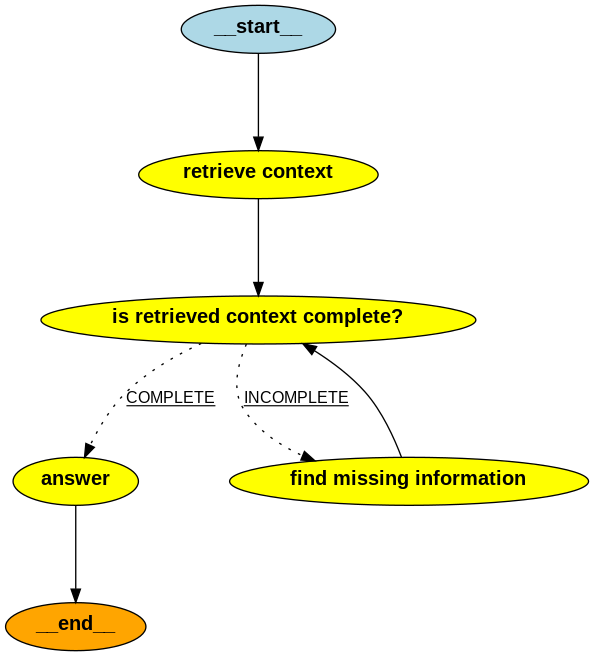

In [26]:
from IPython.display import Image, display

# display(Image(compiled_graph.get_graph(xray=True).draw_mermaid_png()))
draw_graph = compiled_graph.get_graph(xray=True)
display(Image(draw_graph.draw_png()))

In [27]:
qa_df.sample(3)

,uuid,question,answer,context,doc,qa_type,score,score_reason,dataset
324,ecc12483-d88f-41af-93a6-16c48d4ef147,商业房地产贷款在中小型银行资产中的占比大约是多少？,29%,该类贷款在中小银行资产中占比达29%，高于大型银行的6.4%，风险敞口更集中。,全球经济金融展望报告\n中国银行研究院 48 2024年\n该类贷款新发放量将同比下降46%...,detailed,5,问题询问的是具体的数据，是实证性的信息；答案直接给出了数值，符合要求。,test
275,c6fc6079-0daf-4d6a-bd6e-7d9820012425,沙特的全面绿色倡议包含哪些项目？,13个可再生能源项目,沙特绿色倡议包括13个可再生能源项目，计划每年减少约2000万吨碳排放。,全球经济金融展望报告\n中国银行研究院 42 2024年\n供了空间，进一步坚定了海湾六国经...,detailed,4,问题询问的是具体的项目内容，答案直接给出了明确的回应，没有简单地引用原文或做概括性描述。虽然...,test
128,733c7f0b-06fd-40f4-a1de-0c863db6069a,日本通胀同比增速变化的数据来源是哪里？,Wind，中国银行研究院,图12：日本通胀同比增速变化（%）\n资料来源：Wind，中国银行研究院,全球经济金融展望报告\n中国银行研究院 18 2024年\n图12：日本通胀同比增速变化（%...,detailed,5,问题询问的是具体数据来源，答案直接提供了来源机构，符合要求。,train


In [28]:
# result = compiled_graph.invoke({'question': '全球贸易增长情况如何？'})

In [29]:
# result['answer_to_question']

# 批量预测

In [30]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [31]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

In [32]:
# prediction_df = baseline_pred_df[baseline_pred_df['score'] == 0]

In [33]:
prediction_df.shape

(100, 4)

In [34]:
prediction_df.sample(5)

,uuid,question,qa_type,ref_answer
265,28c7d4f0-8cea-48b3-9cfa-6683446fd425,海湾六国经济结构的主要问题是什么？,detailed,经济结构相对单一
247,8cd339ad-8db5-4fa8-adb4-90112436bc6f,11月16日NYMEX天然气的价格是多少？,detailed,3.1美元/百万英热
311,c47057d6-35c0-4466-bafd-4ed036030c1d,在2024年美联储可能做什么？,detailed,开始降息
314,c47057d6-35c0-4466-bafd-4ed036030c1d,疫情后美国商业房地产价格在2021年四季度的季度同比增幅是多少？,detailed,16.4%
211,65b167b2-bf81-4148-b6a6-7afb9946676d,市场对美联储的预期是什么？,detailed,降息


In [35]:
if 'finished_questions' in locals():
    finished_questions = locals()['finished_questions']
else:
    finished_questions = set()
    answer_dict = {}

len(finished_questions), len(answer_dict)

(0, 0)

In [36]:
import time

def rag(llm, query, n_chunks=3):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt).content.strip()
            if resp.startswith('<think>'):
                resp = resp.split('</think>')[1]
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)
    
    return resp, chunks

In [37]:
for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
    uuid = row['uuid']
    question = row['question']
    if question in finished_questions:
        continue

    fallback = 0
    compiled_graph = workflow.compile()
    try:
        result = compiled_graph.invoke({'question': question})
        answer = result['answer_to_question']
    except Exception as e:
        print(f"e: {e}, 兜底")
        fallback = 1
        answer, _ = rag(llm, question)
    
    answer_dict[question] = {
        'uuid': uuid,
        'ref_answer': row['ref_answer'],
        'gen_answer': answer,
        'fallback': fallback
    }
    finished_questions.add(question)

  0%|          | 0/100 [00:00<?, ?it/s]


=== STEP 1: RETRIEVAL (round: 0)===
Searching for: 报告的发布机构是什么？

=== STEP 2: VALIDATION (round: 1)===
structured response: {'status': 'COMPLETE', 'useful_information': '中国银行研究院', 'missing_information': ''}
router decision: COMPLETE

=== STEP 3: ANSWERING (round: 1)===
answer: 中国银行研究院

=== STEP 1: RETRIEVAL (round: 0)===
Searching for: 报告的发布日期是什么时候？

=== STEP 2: VALIDATION (round: 1)===
structured response: {'status': 'COMPLETE', 'useful_information': '报告日期：2023年12月12日', 'missing_information': ''}
router decision: COMPLETE

=== STEP 3: ANSWERING (round: 1)===
answer: 报告的发布日期是2023年12月12日。

=== STEP 1: RETRIEVAL (round: 0)===
Searching for: 2023年全球经济增长有什么特点？

=== STEP 2: VALIDATION (round: 1)===
structured response: {'status': 'COMPLETE', 'useful_information': '2023年全球经济呈现复苏不均衡特点：发达经济体增速放缓（欧元区、英国转负增长，美国超预期增长4.9%），新兴经济体增速持平但区域分化（东南亚、拉美增长承压，中东欧加速）。全球贸易投资下行，货物贸易量价指数双降，跨境直接投资降幅收窄。', 'missing_information': ''}
router decision: COMPLETE

=== STEP 3: ANSWERING (round: 1)===
answer: 2023年全球经济复苏不均

In [38]:
prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
prediction_df.loc[:, 'fallback'] = prediction_df['question'].apply(lambda q: answer_dict[q]['fallback'])

In [39]:
prediction_df['fallback'].sum()

5

# 评估

In [40]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in prediction_df.iterrows():
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [41]:
prediction_df['raw_score'] = evaluate(prediction_df)

In [42]:
prediction_df['raw_score'].unique()

array(['是', '否'], dtype=object)

In [43]:
prediction_df['score'] = (prediction_df['raw_score'] == '是').astype(int)

In [44]:
prediction_df['score'].mean()

0.72

In [45]:
prediction_df['score'].sum()

72

In [46]:
prediction_df['fallback'].sum()

5

有4条发生兜底

<Axes: xlabel='fallback', ylabel='score'>

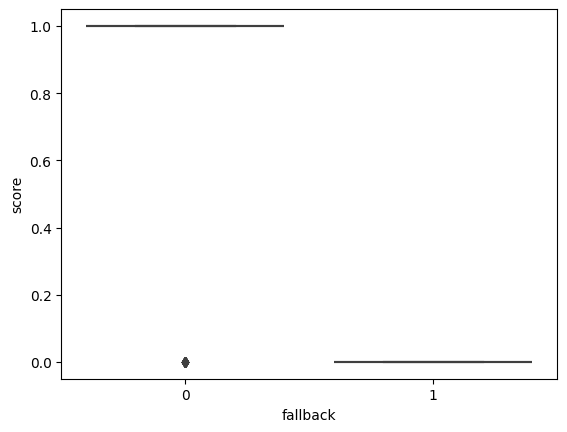

In [47]:
import seaborn as sns

sns.boxplot(x='fallback', y='score', data=prediction_df)